In [1]:
import math
import glob
import json
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, functions as F, types as T, Window as W

In [2]:
# Set up the Spark configuration and context
conf = SparkConf().setAppName("MyApp").setMaster("local[*]")
sc = SparkContext(conf=conf)

# Set up the Spark session
spark = SparkSession.builder \
    .appName("BatchProcessor") \
    .config("spark.driver.extraJavaOptions", "-Xss4m") \
    .config("spark.executor.extraJavaOptions", "-Xss4m") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/07 02:25:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/12/07 02:25:58 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/12/07 02:25:58 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/12/07 02:25:58 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


# Data Preparation

In [3]:
schema = T.StructType([
    T.StructField("authors", T.ArrayType(T.StringType()), True),
    T.StructField("date_google", T.StringType(), True),
    T.StructField("date_metadata", T.StringType(), True),
    T.StructField("date_published", T.StringType(), True),
    T.StructField("date_target", T.StringType(), True),
    T.StructField("description", T.StringType(), True),
    T.StructField("explanation", T.StringType(), True),
    T.StructField("groq_usage", T.StringType(), True),
    T.StructField("metadata", T.MapType(T.StringType(), T.StringType()), True),
    T.StructField("rating_democrats", T.FloatType(), True),
    T.StructField("rating_republicans", T.FloatType(), True),
    T.StructField("source_url", T.StringType(), True),
    T.StructField("summary", T.StringType(), True),
    T.StructField("text", T.StringType(), True),
    T.StructField("title", T.StringType(), True),
    T.StructField("url", T.StringType(), True)
])
news_df = spark.read.option("multiline", "true").json("../news_ratings/data/", schema=schema)
news_df.show(n=5)

+--------------------+-------------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+----------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|             authors|        date_google|       date_metadata|     date_published|        date_target|         description|         explanation|          groq_usage|            metadata|rating_democrats|rating_republicans|          source_url|             summary|                text|               title|                 url|
+--------------------+-------------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+----------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|            

In [4]:
market_df = spark.read.csv("../stocks_data/ticker_data.csv", header=True, inferSchema=True)
market_df.show(n=5)

+------+-------------------+------------------+------------------+------------------+------------------+------------------+-----------+
|Ticker|               Date|              Open|              High|               Low|             Close|         Adj Close|     Volume|
+------+-------------------+------------------+------------------+------------------+------------------+------------------+-----------+
|  COIN|2023-11-16 14:30:00| 97.68000030517578| 97.79000091552734| 95.04000091552734| 97.01000213623047| 97.01000213623047|  2528149.0|
|   XOM|2023-11-16 14:30:00| 102.9000015258789| 103.2699966430664|101.98999786376953|102.37999725341797|102.37999725341797|  4463991.0|
| ^GSPC|2023-11-16 14:30:00|    4497.080078125|    4511.990234375|   4495.7001953125|           4505.75|           4505.75|        0.0|
|   SPY|2023-11-16 14:30:00| 449.2200012207031|450.55999755859375| 449.1300048828125|449.95001220703125|449.95001220703125|1.0474895E7|
|   XLI|2023-11-16 14:30:00|105.02999877929688| 

# Data Pre-processing

In [5]:
news_df = news_df.withColumn("published_at", F.coalesce("date_google", "date_metadata", "date_published")) \
    .withColumn("published_at", F.to_timestamp("published_at")) \
    .withColumn("date_target", F.to_date("date_target"))
news_df = news_df.select('published_at', 'date_target', 'rating_democrats', 'rating_republicans', 'title', 'summary', 'url')
news_df = news_df.na.drop(subset=["published_at"])
news_df.sample(fraction=0.01, seed=1947).show(n=5)

+-------------------+-----------+----------------+------------------+--------------------+--------------------+--------------------+
|       published_at|date_target|rating_democrats|rating_republicans|               title|             summary|                 url|
+-------------------+-----------+----------------+------------------+--------------------+--------------------+--------------------+
|2024-02-14 22:16:42| 2024-02-13|             4.0|              -3.0|New York special ...| Democrat Tom Suo...|https://www.thegu...|
|2024-02-15 03:46:44| 2024-02-13|             0.0|               0.0|Prabowo Subianto ...| Prabowo Subianto...|https://www.aljaz...|
|2024-04-29 19:13:08| 2024-02-22|             1.0|              -1.0|US Troops to Stay...| There have been ...|https://arabcente...|
|2024-02-24 04:21:17| 2024-02-23|             0.0|              -2.0|February 23 - 202...| South Carolina s...|https://www.cnn.c...|
|2024-02-26 18:00:00| 2024-02-25|             2.0|              -2.0|

In [6]:
market_df = (
    market_df
    .withColumn("hour_bucket", F.date_trunc("day", F.col("Date")))
)
news_df = (
    news_df
    .withColumn("hour_bucket", F.date_trunc("day", F.col("published_at")))
)

In [7]:
stat_exprs = []
for col in ['rating_democrats', 'rating_republicans']:
    stat_exprs.append(F.min(col).alias(f"{col}_min"))
    stat_exprs.append(F.max(col).alias(f"{col}_max"))
    stat_exprs.append(F.sum(col).alias(f"{col}_sum"))
    stat_exprs.append(F.count(col).alias(f"{col}_count"))
news_agg_df = news_df.groupBy("hour_bucket").agg(
    F.count("*").alias("total_count"),
    *stat_exprs
)

In [8]:
news_agg_df.show(n=10)

+-------------------+-----------+--------------------+--------------------+--------------------+----------------------+----------------------+----------------------+----------------------+------------------------+
|        hour_bucket|total_count|rating_democrats_min|rating_democrats_max|rating_democrats_sum|rating_democrats_count|rating_republicans_min|rating_republicans_max|rating_republicans_sum|rating_republicans_count|
+-------------------+-----------+--------------------+--------------------+--------------------+----------------------+----------------------+----------------------+----------------------+------------------------+
|2024-03-28 00:00:00|         26|                 0.0|                 4.0|                23.0|                    26|                  -2.0|                   1.0|                 -11.0|                      26|
|2034-02-07 00:00:00|          2|                 1.0|                 1.0|                 2.0|                     2|                   0.0|  

In [9]:
df = news_agg_df.orderBy("hour_bucket").toPandas()
df.head()


,hour_bucket,total_count,rating_democrats_min,rating_democrats_max,rating_democrats_sum,rating_democrats_count,rating_republicans_min,rating_republicans_max,rating_republicans_sum,rating_republicans_count
0,2007-06-22,1,0.0,0.0,0.0,1,0.0,0.0,0.0,1
1,2017-01-20,1,1.0,1.0,1.0,1,-1.0,-1.0,-1.0,1
2,2019-07-25,1,4.0,4.0,4.0,1,-3.0,-3.0,-3.0,1
3,2020-11-03,1,0.0,0.0,0.0,1,0.0,0.0,0.0,1
4,2021-02-05,1,-3.0,-3.0,-3.0,1,2.0,2.0,2.0,1


In [10]:
df = df.loc[(df['hour_bucket'] >= '2024-01-01') & (df['hour_bucket'] <= '2024-12-01')]

In [ ]:
df['rating_democrats_mean'] = df['rating_democrats_sum'] / df['rating_democrats_count']
df['rating_republicans_mean'] = df['rating_republicans_sum'] / df['rating_republicans_count']
df['net_favourability'] = df['rating_democrats_mean'] - df['rating_republicans_mean']
df['daily_change'] = df['net_favourability'].diff()

threshold = df['daily_change'].std()
df['significant_swing'] = df['daily_change'].abs() > threshold * 1.5
swing_dates = df[df['significant_swing']]['hour_bucket']

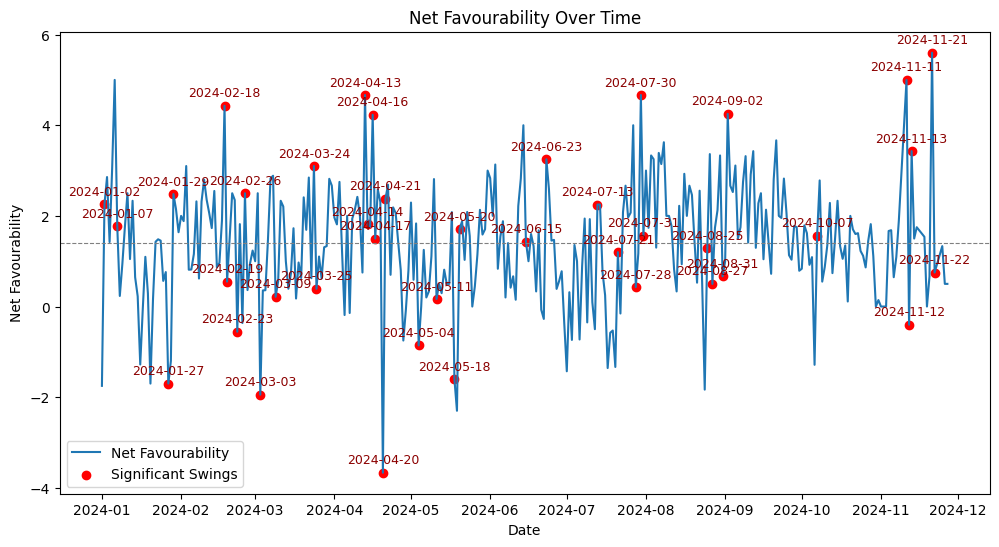

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df['hour_bucket'], df['net_favourability'], label='Net Favourability')
plt.scatter(swing_dates, df[df['significant_swing']]['net_favourability'], label='Significant Swings', color='red')

# Annotate the significant swing points
swing_dates = df[df['significant_swing']].reset_index()
for _, row in swing_dates.iterrows():
    plt.text(row['hour_bucket'], row['net_favourability'] + 0.2,  # Adjust y-offset for better visibility
             row['hour_bucket'].strftime('%Y-%m-%d'),
             fontsize=9, ha='center', color='darkred')

plt.axhline(df['net_favourability'].mean(), color='gray', linestyle='--', linewidth=0.8)
plt.axhline(0, color='green', linestyle='-', linewidth=0.8)
plt.title('Net Favourability Over Time')
plt.xlabel('Date')
plt.ylabel('Net Favourability')
plt.legend()
plt.show()

In [ ]:
# split into training and test sets by date 2024-11-01
train_test_split_point = pd.to_datetime('2024-09-01')
train = df[df['hour_bucket'] < train_test_split_point]
test = df[df['hour_bucket'] >= train_test_split_point]

In [ ]:
# plot train-test split
fig, ax = plt.subplots(figsize=(15, 5))
train['Close'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test['Close'].plot(ax=ax, label='Test Set')
ax.axvline(train_test_split_point, color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()